In [1]:
import os

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')

from utilities2014 import *

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from skimage.filters import gaussian_filter
from joblib import Parallel, delayed
from skimage.util import img_as_ubyte

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=1)
dm._load_image()

In [4]:
smooth_sigma = 10
smoothed_im = gaussian_filter(dm.image, smooth_sigma)
dy, dx = np.gradient(smoothed_im)

In [15]:
display(smoothed_im)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [5]:
pool_sigma = 50
dx2 = gaussian_filter(dx*dx, pool_sigma)
dxdy = gaussian_filter(dx*dy, pool_sigma)
dy2 = gaussian_filter(dy*dy, pool_sigma)
M = np.array([[dx2, dxdy],[dxdy, dy2]])
M = np.rollaxis(np.rollaxis(M, 2), 3, 1)
M = M.reshape((-1,2,2))

In [13]:
def tensors_eigh(tensors):
    n = len(tensors)
    vec = np.empty((n, 2))
    coh = np.empty((n, ))
    for i, m in enumerate(tensors):
        w, v = np.linalg.eigh(m)
        coh[i] = ((w[0]-w[1])/(w[0]+w[1]))**2
        vec[i] = v[:, np.argmax(np.abs(w))]
    return coh, vec
        
res = Parallel(n_jobs=16)(delayed(tensors_eigh)(tensors) for tensors in np.array_split(M, 16))

cohs, vecs = zip(*res)
coherence_map = np.reshape(np.concatenate(cohs), dm.image.shape)
eigenvec_map = np.reshape(np.vstack(vecs), (dm.image.shape[0], dm.image.shape[1], -1))

dm.save_pipeline_result(coherence_map, 'coherenceMap', 'npy')
dm.save_pipeline_result(eigenvec_map, 'eigenvecMap', 'npy')

saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0006/RS141_x5_0006_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_coherenceMap.npy
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0006/RS141_x5_0006_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_eigenvecMap.npy


In [12]:
coherence_map = dm.load_pipeline_result('coherenceMap', 'npy')
eigenvec_map = dm.load_pipeline_result('eigenvecMap', 'npy')

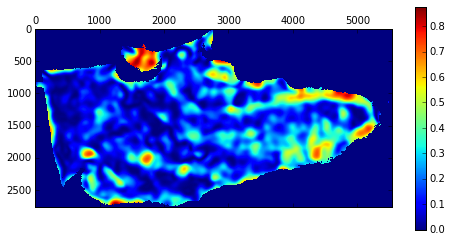

In [13]:
vmap = coherence_map.copy()
vmap[~dm.mask] = 0
plt.matshow(vmap);
plt.colorbar(); 

In [14]:
display(plt.cm.jet(vmap))

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [14]:
# segmentation_vis = dm.load_pipeline_result('segmentationWithoutText', 'jpg')
# viz = img_as_ubyte(segmentation_vis)

viz = img_as_ubyte(dm.image_rgb.copy())

# viz = img_as_ubyte(np.ones_like(dm.image_rgb))

xs, ys = np.mgrid[:dm.image_width:30, :dm.image_height:30]
for x,y in np.c_[xs.flat, ys.flat]:
    
    if coherence_map[y,x] < .1:
        continue
    
    if not dm.mask[y,x]: continue
    vec = eigenvec_map[y,x]
    angle = np.arctan2(vec[1], vec[0])
    length = coherence_map[y,x]*500 if not np.isnan(coherence_map[y,x]) else 0
    end = [x,y] + np.array([length*np.sin(angle), -length*np.cos(angle)], dtype=np.int)
    cv2.line(viz, (x,y), tuple(end), (255,0,0), thickness=5, lineType=8, shift=0)
    
display(viz)
# dm.save_pipeline_result(viz, 'structureTensorMap', 'jpg')

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [15]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg